# Проверка гипотез и анализ результатов А/Б теста

- Автор: Вермишян Валерий
- Дата: 07.08.2025

# Часть 1. Проверка гипотезы в Python и составление аналитической записки

## Цели и задачи проекта

**Цель**: проверить гипотезу о том, что пользователи приложения Яндекс Книги в Санкт-Пететрбурге проводят в среднем больше времени за чтением и прослушиванием книг, чем пользователи из Москвы

**Задачи**: 
- Загрузить данные и ознакомиться с ними
- Выбрать параметры теста
- Проверить гипотезу
- Сформировать аналитическую записку

## Описание данных

Датасет - `yandex_knigi_data` состоит из столбцов:

- `Unnamed: 0` - id строки, начиная с 0
- `city` - город пользователя. Москва или Санкт-Петербург
- `puid` - id пользователя
- `hours` - суммарное кол-во часов активности

## Загрузка данных и знакомство с ними

In [1]:
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from statsmodels.stats.proportion import proportions_ztest

In [2]:
df = pd.read_csv('yandex_knigi_data.csv')

print(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8784 non-null   int64  
 1   city        8784 non-null   object 
 2   puid        8784 non-null   int64  
 3   hours       8784 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 274.6+ KB
None


,Unnamed: 0,city,puid,hours
0,0,Москва,9668,26.167776
1,1,Москва,16598,82.111217
2,2,Москва,80401,4.656906
3,3,Москва,140205,1.840556
4,4,Москва,248755,151.326434


In [3]:
# Проверим кол-во уникальных значений
for col in df.columns:
    print(f'В столбце {col} - {df[col].nunique()} уникальных значений. Например:')
    print(df[col].unique())

В столбце Unnamed: 0 - 8784 уникальных значений. Например:
[   0    1    2 ... 8781 8782 8783]
В столбце city - 2 уникальных значений. Например:
['Москва' 'Санкт-Петербург']
В столбце puid - 8540 уникальных значений. Например:
[            9668            16598            80401 ... 1130000038726322
 1130000047892100 1130000061443598]
В столбце hours - 8025 уникальных значений. Например:
[26.16777639 82.11121667  4.65690606 ...  0.21194444  4.31184146
 20.84722222]


In [4]:
#Сделаем 2 столбец индексом
df.set_index('Unnamed: 0', inplace=True)

In [5]:
# Проверим наличие явных дублей
print(f'{df.duplicated().sum()} явных дублей строк')

0 явных дублей строк


In [6]:
#Удалим строки с дублями puid. Причем полностью, так как мы не знаем, какая из строк является корректной
df.drop_duplicates(subset='puid', keep=False, inplace=True)

In [7]:
#Оценим статистики выборок
df_moscow = df[df['city'] == 'Москва']
df_spb = df[df['city'] == 'Санкт-Петербург']

print('Статистики пользователей из Москвы')
print(df_moscow['hours'].describe())
print()
print('Статистики пользователей из Санкт-Петербурга')
print(df_spb['hours'].describe())

Статистики пользователей из Москвы
count    5990.000000
mean       10.848192
std        36.925622
min         0.000022
25%         0.057042
50%         0.888232
75%         5.933439
max       857.209373
Name: hours, dtype: float64

Статистики пользователей из Санкт-Петербурга
count    2306.000000
mean       11.264433
std        39.831755
min         0.000025
25%         0.060173
50%         0.875355
75%         6.138424
max       978.764775
Name: hours, dtype: float64


**Итоговый вывод о датафрейме и выборках**

Датафрейм содержит информацию о сумме времени активности пользователей пользователей Яндекс Книг в Москве и СПБ

8784 строки и 4 столбца:
- `Unnamed: 0` - id пользователя. 8784 уникальных значения от 0 до 8783. Столбец соответствует индексу, поэтому превратим его в индекс.
- `city` - город пользователя. 2 уникальных значения
- `puid` - id пользователя. 8540 уникальных значения, значит есть дубли, от них избавились
- `hours` - сумма времени активностей пользователей.
______
- Типы данных корректные
- Пропусков нет
- 0 явных дублей строк
______
- Видно, что пользователей из Москвы значительно больше чем из Санкт-Петербурга.

Что касается показателя `hours`, то показетели примерно рядом. Значения Санкт-Петербурга немного преобладают везде кроме медианы

## Проверка гипотезы в Python

- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

In [8]:
# Создадим 2 серии hours для каждого города, выведем кол-во значений и их среднее
hours_moscow = df[df['city'] == 'Москва']['hours']
hours_spb = df[df['city'] == 'Санкт-Петербург']['hours']

print(f'Кол-во пользователей из Москвы = {len(hours_moscow)}, их среднее = {hours_moscow.mean()} ')
print(f'Кол-во пользователей из Санкт-Петербурга = {len(hours_spb)}, их среднее = {hours_spb.mean()}')

Кол-во пользователей из Москвы = 5990, их среднее = 10.84819150713916 
Кол-во пользователей из Санкт-Петербурга = 2306, их среднее = 11.264433367029522


В качестве статистического теста используем t-тест с 2 выборками, так как мы сравниваем средние значения двух разных выборок с близкими значениями дисперсий

In [9]:
# Проведем t-test с 2 выборками

# Задаем уровень стат значимости
alpha = 0.05

statistic, pvalue = st.ttest_ind(hours_moscow, hours_spb, alternative='greater')

if pvalue < alpha:
    print(f'pvalue={round(pvalue,2)}, нулевая гипотеза не находит подтверждение. Принимаем альтернативную гипотезу')
else:
    print(f'pvalue={round(pvalue,2)}, альтернативная гипотеза не находит подтверждения. Верна нулевая гипотеза')

pvalue=0.67, альтернативная гипотеза не находит подтверждения. Верна нулевая гипотеза


## Аналитическая записка:

- Выбранный тип t-теста - ttest_ind
- Уровень статистической значимости = 0.05
- p-value = 0.67
- p-value > уровня статистической значимости, поэтому будем считать верной нулевую гипотезу
- Предположу, что имеющихся данных слишком мало для того, чтобы считать статистически значимой разницу средних значений. Видно, что кол-во пользователей в СПБ в 2,5 раза меньше, чем в Москве

----

# Часть 2. Анализ результатов A/B-тестирования

К нам обратились представители интернет-магазина BitMotion Kit, в котором продаются геймифицированные товары для тех, кто ведёт здоровый образ жизни. У него есть своя целевая аудитория, даже появились хиты продаж: эспандер со счётчиком и напоминанием, так и подстольный велотренажёр с Bluetooth.

В будущем компания хочет расширить ассортимент товаров. Но перед этим нужно решить одну проблему. Интерфейс онлайн-магазина слишком сложен для пользователей — об этом говорят отзывы.

Чтобы привлечь новых клиентов и увеличить число продаж, владельцы магазина разработали новую версию сайта и протестировали его на части пользователей. По задумке, это решение доказуемо повысит количество пользователей, которые совершат покупку.

Задача — провести оценку результатов A/B-теста.

## Цель исследования.



**Цель исследования**: оценить влияние новой версии сайта на % пользователей, которые совершают покупку

## Загрузка данных, и оценка их целостности


In [10]:
participants = pd.read_csv('ab_test_participants.csv')
events = pd.read_csv('ab_test_events.csv',
                     parse_dates=['event_dt'], low_memory=False)

Изучим датафрейм `participants`

In [11]:
# Выведем основную информацию
display(participants.info())
display(participants.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
 3   device   14525 non-null  object
dtypes: object(4)
memory usage: 454.0+ KB


None

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac


In [12]:
# Проверим кол-во уникальных значений
for col in participants.columns:
    print(f'В столбце {col} - {participants[col].nunique()} уникальных значений. Например:')
    print(participants[col].unique())

В столбце user_id - 13638 уникальных значений. Например:
['0002CE61FF2C4011' '001064FEAAB631A1' '0010A1C096941592' ...
 'FFEFC0E55C1CCD4F' 'FFF28D02B1EACBE1' 'FFF58BC33966EB51']
В столбце group - 2 уникальных значений. Например:
['B' 'A']
В столбце ab_test - 2 уникальных значений. Например:
['interface_eu_test' 'recommender_system_test']
В столбце device - 4 уникальных значений. Например:
['Mac' 'Android' 'iPhone' 'PC']


In [13]:
# Проверим наличие явных дублей
print(f'{participants.duplicated().sum()} явных дублей строк')

0 явных дублей строк


**Итоговый вывод о датафрейме `participants`**

Датафрейм `participants` содержит информацию о пользователях, принимающих участие в а/б тестах

14525 строк и 4 столбца:
- `user_id` - id пользователя. 13638 уникальных значений (возможно есть дубли из-за наличия 2 разных тестов)
- `group` - тестовая группа. 2 уникальных значения, столбец корректный
- `ab_test` - название теста. 2 уникальных значения, так как в данных представлены 2 разных теста, столбец корректный
- `device` - устройство. 4 уникальных значения, столбец корректный
______
- Типы данных корректные
- 0 явных пропусков
- 0 явных дублей строк


Изучим датафрейм `events`

In [14]:
# Выведем основную информацию
display(events.info())
display(events.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787286 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     787286 non-null  object        
 1   event_dt    787286 non-null  datetime64[ns]
 2   event_name  787286 non-null  object        
 3   details     249022 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 24.0+ MB


None

,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN


In [15]:
# Проверим кол-во уникальных значений
for col in events.columns:
    print(f'В столбце {col} - {events[col].nunique()} уникальных значений. Например:')
    print(events[col].unique())

В столбце user_id - 144184 уникальных значений. Например:
['GLOBAL' 'CCBE9E7E99F94A08' 'AA346F4D22148024' ... 'B77B2F4BCA134618'
 'B12AD1623E494FAD' '5456977474344433']
В столбце event_dt - 606573 уникальных значений. Например:
<DatetimeArray>
['2020-12-01 00:00:00', '2020-12-01 00:00:11', '2020-12-01 00:00:25',
 '2020-12-01 00:00:33', '2020-12-01 00:00:52', '2020-12-01 00:01:46',
 '2020-12-01 00:02:06', '2020-12-01 00:02:20', '2020-12-01 00:02:37',
 '2020-12-01 00:02:53',
 ...
 '2020-12-31 23:56:46', '2020-12-31 23:56:56', '2020-12-31 23:57:28',
 '2020-12-31 23:57:31', '2020-12-31 23:57:35', '2020-12-31 23:57:44',
 '2020-12-31 23:58:23', '2020-12-31 23:58:30', '2020-12-31 23:58:34',
 '2020-12-31 23:59:48']
Length: 606573, dtype: datetime64[ns]
В столбце event_name - 8 уникальных значений. Например:
['End of Black Friday Ads Campaign' 'registration' 'product_page' 'login'
 'product_cart' 'purchase' 'Start of Christmas&New Year Promo'
 'Start of CIS New Year Gift Lottery']
В столбце det

In [16]:
# Проверим мин и макс значения даты действия:
min(events['event_dt']), max(events['event_dt'])

(Timestamp('2020-12-01 00:00:00'), Timestamp('2020-12-31 23:59:48'))

In [17]:
# Изучим подробнее действия 'End of Black Friday Ads Campaign', 'Start of Christmas&New Year Promo', 'Start of CIS New Year Gift Lottery'
ev = ['End of Black Friday Ads Campaign', 
       'Start of Christmas&New Year Promo', 
     'Start of CIS New Year Gift Lottery']

display(events[events.event_name.isin(ev)].head())
print('Всего строк:', len(events[events.event_name.isin(ev)]))

,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01,End of Black Friday Ads Campaign,ZONE_CODE15
683503,GLOBAL,2020-12-25,Start of Christmas&New Year Promo,ZONE_CODE09
773846,GLOBAL,2020-12-30,Start of CIS New Year Gift Lottery,ZONE_CODE02


Всего строк: 3


In [18]:
# Изучим подробнее столбец "details"
# Выгрузим информацию о датафрейме, где это значение непустое и посмотрим, для каких действий оно характерно:
display(events[~events['details'].isna()]['event_name'].value_counts())

# Теперь посмотрим, сколько всего каждого действия было совершено в изначальном датафрейме
display(events['event_name'].value_counts())

event_name
registration                          144183
purchase                              104836
End of Black Friday Ads Campaign           1
Start of Christmas&New Year Promo          1
Start of CIS New Year Gift Lottery         1
Name: count, dtype: int64

event_name
login                                 248285
product_page                          195606
registration                          144183
purchase                              104836
product_cart                           94373
End of Black Friday Ads Campaign           1
Start of Christmas&New Year Promo          1
Start of CIS New Year Gift Lottery         1
Name: count, dtype: int64

In [19]:
# Проверим наличие явных дублей
print(f'{events.duplicated().sum()} явных дублей строк')

36318 явных дублей строк


In [20]:
# Удалим дубли
events.drop_duplicates(subset=None, keep='first', inplace=True)

**Итоговый вывод о датафрейме `events`**

Датафрейм `events` содержит информацию о действиях, совершенных пользователями с 1 по 31 декабря

787 286 строк и 4 столбца:
- `user_id` - id пользователя. 144 184 уникальных значения, столбец корректный
- `event_dt` - дата действия. 606 573 уникальных значения, столбец корректный
- `event_name` - название действия. 8 уникальных значений, в основном описаны действия пользователей, но есть 3 действия, связанные с запусками промо или рекламы, которые судя по всему совершались от лица сайта (user_id = GLOBAL). Столбец корректный
- `details` - детали действия. 169 уникальных значений. Это поле непустое для всех покупок, регистраций и для глобальных действий. Этот столбец в основном принимает значения в виде вещественного числа, которое может быть отрицательным, положительным, равным нулю. Для глобальных действий столбец принимает значение вида "ZONE_CODE15", где отличается только числом в конце. Пока непонятно, что оно может значить
______
- Типы данных корректные
- Есть явные пропуски в столбце `details`
- 36318 явных дублей строк. Их мы удалили


## По таблице `ab_test_participants` оценим корректность проведения теста:

In [21]:
# Выделим пользователей, участвующих в тесте
participants_interface_test = participants[participants['ab_test']=='interface_eu_test'].copy()

In [22]:
# Проверим равномерность распределения пользователей по группам теста

# группируем кол-во уникальных пользователей по тестовым группам
uniq_users = participants_interface_test.groupby('group', as_index=False)['user_id'].nunique()

# считаем процентную разницу в кол-ве пользователей
P = 100 * (abs(uniq_users.iloc[0,1] - uniq_users.iloc[1,1])/uniq_users.iloc[0,1])

print(f'Разница в кол-ве пользователей в двух группах составляет {round(P,1)}%')

Разница в кол-ве пользователей в двух группах составляет 1.6%


<Figure size 1500x700 with 0 Axes>

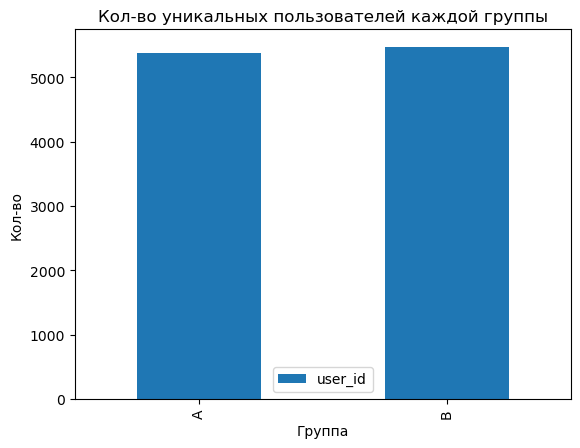

In [23]:
# строим столбчатую диаграмму кол-ва уникальных пользователей каждой группы
plt.figure(figsize=(15,7))

uniq_users.plot.bar(x='group', y='user_id')

plt.title('Кол-во уникальных пользователей каждой группы')
plt.xlabel('Группа')
plt.ylabel('Кол-во')
plt.show()

In [24]:
# Проверим пересечение пользователей в двух тестовых группах
if len(participants_interface_test) == participants_interface_test['user_id'].nunique():
    print('Пользователи не пересекаются')

Пользователи не пересекаются


In [25]:
# Проверим пересечение пользователей группы B в двух тестах

# Создадим списки пользователей для каждого теста
participants_interface_eu_test = participants[(participants['ab_test'] == 'interface_eu_test') &
                                             (participants['group'] == 'B')]['user_id']
participants_recommender_system_test = participants[(participants['ab_test'] == 'recommender_system_test') &
                                                   (participants['group'] == 'B')]['user_id']

#получим пересечения
intersection_users = set(participants_interface_eu_test)&set(participants_recommender_system_test)
print(f'Всего {len(intersection_users)} пользователей групп B находятся в обоих тестах.')

Всего 116 пользователей групп B находятся в обоих тестах.


**Промежуточный вывод:**

- Пользователи нормально распределены по группам, разница в 1,6% не критична
- Пользователи не пересекаются между группами
- 116 пользователей групп B пересекаются между тестами, далее удалим их

Проанализируем данные о пользовательской активности по таблице `ab_test_events`:

- оставьте только события, связанные с участвующими в изучаемом тесте пользователями;

In [26]:
# Присоединим к таблице events информацию из таблицы participants_interface_test
events_participants = events.merge(participants_interface_test, on='user_id', how='left')
# Удалим действия пользователей, которые не участвуют в тесте
events_participants.dropna(subset=['group'], inplace=True)
# Удалим столбец ab_test, так как он избыточен
del events_participants['ab_test']

In [27]:
# Удалим пользователей, которые присутствуют в двух тестах
events_participants = events_participants[~events_participants['user_id'].isin(intersection_users)]

- определим горизонт анализа: рассчитаем время совершения события пользователем после регистрации и оставим только те события, которые были выполнены в течение первых семи дней с момента регистрации

In [28]:
# Оставим в датафрейме только регистрации
registration_dt = events_participants[events_participants['event_name'] == 'registration']

# Проверим, у всех ли пользователей есть ровно одно событие "регистрация"
if events_participants['user_id'].nunique() == registration_dt['user_id'].nunique() == len(registration_dt):
    print('У всех пользователей в базе есть ровно одно событие "регистрация"')

У всех пользователей в базе есть ровно одно событие "регистрация"


In [29]:
# Переименуем столбец event_dt, удалим ненужные столбцы и присоединим значения к таблице events_participants
registration_dt.rename(columns={'event_dt': 'registration_dt'}, inplace=True)
registration_dt = registration_dt[['user_id','registration_dt']]
    
events_participants = events_participants.merge(registration_dt, on='user_id', how='left')

/var/folders/j0/t_q57p5s5cd5c9lzd6y7scs80000gn/T/ipykernel_31234/2144951459.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  registration_dt.rename(columns={'event_dt': 'registration_dt'}, inplace=True)


In [30]:
# Посчитаем разницу между registration_dt и event_dt
events_participants['dif_dt'] = events_participants['event_dt'] - events_participants['registration_dt']
# Оставим только те строки, где разница <= 7 дней и событие не является регистрацией
events_participants = events_participants[(events_participants['dif_dt'] < '7 days') & 
                                         (events_participants['event_name'] != 'registration')]

In [31]:
print(f'Получили {len(events_participants)} строк')

Получили 52200 строк


Оценим достаточность выборки для получения статистически значимых результатов A/B-теста. 

In [32]:
# Посчитаем кол-во событий для каждой группы
events_A = events_participants[events_participants['group'] == 'A']
events_B = events_participants[events_participants['group'] == 'B']

print(f'В группе A - {len(events_A)} событий')
print(f'В группе B - {len(events_B)} событий')

В группе A - 25771 событий
В группе B - 26429 событий


In [33]:
# Задаем параметры
alpha = 0.05 # ошибка 1 рода. 1 - достоверность теста
beta = 0.2 # ошибка 2 рода
power = 1-beta # мощность
p1 = 0.3 # базовый показатель конверсии
mde = 0.02 # Минимальный детектируемый эффект
effect_size = proportion_effectsize(p1,p1+mde)

# Инициализируем класс NormalIndPower для расчета размера выборки
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"При MDE = {mde} необходимый размер выборки событий для каждой группы: {int(sample_size)}")

При MDE = 0.02 необходимый размер выборки событий для каждой группы: 8392


Выборка событий в нашем тесте удовлетворяет условию минимального размера выборки

- рассчитаем для каждой группы количество посетителей, сделавших покупку, и общее количество посетителей.

In [34]:
# Посчитаем кол-во посетителей всего
users_total_A = events_A['user_id'].nunique()
users_total_B = events_B['user_id'].nunique()

# Посчитаем кол-во посетителей, сделавших покупку
users_purchase_A = events_A[events_A['event_name'] == 'purchase']['user_id'].nunique()
users_purchase_B = events_B[events_B['event_name'] == 'purchase']['user_id'].nunique()

crA = round(users_purchase_A/users_total_A*100,2)
crB = round(users_purchase_B/users_total_B*100,2)

print(f'В группе A всего {users_total_A} пользователей {users_purchase_A} пользователей, совершивших покупку. \
CR - {crA}%')
print(f'В группе B всего {users_total_B} пользователей {users_purchase_B} пользователей, совершивших покупку. \
CR - {crB}%')

В группе A всего 5383 пользователей 1480 пользователей, совершивших покупку. CR - 27.49%
В группе B всего 5351 пользователей 1579 пользователей, совершивших покупку. CR - 29.51%


In [35]:
# считаем рост CR в п. п.
print(f'В тестовой группе CR вырос на {round((crB-crA),2)} п.п.')
print(f'Это на {round((crB-crA)-2,2)} п.п. больше планового значения')

В тестовой группе CR вырос на 2.02 п.п.
Это на 0.02 п.п. больше планового значения


## Проведем оценку результатов A/B-тестирования:

Сформулируем гипотезы:

Будем работать с метрикой "Доля покупок, от всех событий"

- Нулевая гипотеза - значение метрики одинаково для каждой из групп
- Альтернативная гипотеза - значение метрики выше в тестовой группе

Проведем z-test пропорций. Выбираем этот тест, так как сравниваем конверсии

In [36]:
n_a = users_total_A
n_b = users_total_B
m_a = users_purchase_A
m_b = users_purchase_B
p_a, p_b = m_a/n_a, m_b/n_b

if (p_a*n_a > 10)and((1-p_a)*n_a > 10)and(p_b*n_b > 10)and((1-p_b)*n_b > 10):
    print('Предпосылка о достаточном количестве данных выполняется!')
else:
    print('Предпосылка о достаточном количестве данных НЕ выполняется!')
    
stat_ztest, p_value_ztest = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative='smaller'
)

print(f'pvalue={p_value_ztest}')

if p_value_ztest > alpha:
    print('Нулевая гипотеза находит подтверждение!')
    print(f'При переходе на новый сайт доля покупок среди всех сессий не увеличилась')
else:
    print('Нулевая гипотеза не находит подтверждения!')
    print(f'При переходе на новый сайт доля покупок среди всех сессий увеличилась')

Предпосылка о достаточном количестве данных выполняется!
pvalue=0.010393282955333765
Нулевая гипотеза не находит подтверждения!
При переходе на новый сайт доля покупок среди всех сессий увеличилась


**Выводы:**

Был проведен а/б-тест нового сайта.

Характеристики эксперимента:

- Эксперимент длился 22 дня. В группе А было задействовано 5383 пользователй, в группе B - 5351.
- В качестве целевой метрики была выбрана доля пользователей, совершивших покупку, от всех пользователей за период в 7 дней с момента регистрации для каждого пользователя
- Уровень значимости — 0.05.
- Вероятность ошибки второго рода — 0.2.

По результатам а/б-теста можно сказать, что внедрение нового сайта положительно повлияло на % покупок. Метрика выросла на 2,02 п.п.

Нововведение стоит внедрить